### Random Forest Model Interpretation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Downloading the Libraries

In [26]:
# from fastai.imports import *
# from fastai.structured import *
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import graphviz

# from pandas_summary import DataFrameSummary
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn.tree import export_graphviz
from sklearn.ensemble import forest
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
# from concurrent.futures import ProcessPoolExecutor

from sklearn import metrics

In [3]:
def set_plot_sizes(sml, med, big):
    plt.rc('font', size=sml)
    plt.rc('axes', titlesize=sml)
    plt.rc('axes', labelsize=med)
    plt.rc('xtick', labelsize=sml)
    plt.rc('ytick', labelsize=sml)
    plt.rc('legend', fontsize=sml)
    plt.rc('figure', titlesize=big)

In [4]:
set_plot_sizes(12, 14, 16)

### Loading the Data

In [5]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None, prepoc_fn=None, max_n_cat=None,
           subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset:
        df = get_sample(df, subset)
    else:
        df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if prepoc_fn: prepoc_fn(df)
    if y_fld is None: y=None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)
    
    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n, c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n, c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [6]:
def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict): 
            df[name + '_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [7]:
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and (max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1

In [8]:
def get_sample(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [9]:
def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
                                      forest.check_random_state(rs).randit(0, n_samples, n))

In [10]:
def reset_rf_samples():
    forest._generate_sample_indices = (lambda rs, n_samples:
                                      forest.check_random_state(rs).randit(0, n_samples, n_samples))

In [11]:
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

In [12]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [13]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [14]:
def apply_cats(df, trn):
    for n, c in df.items():
        if trn[n].dtype.name == "category":
            df[n] = pd.Categorical(c, categories = trn[n].cat.categories, ordered = True )

In [15]:
def add_datepart(df, fldname, drop = True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format = True)
    targ_pre = re.sub("[Dd]ate$", '', fldname)
    for n in ('Year', 'Month', 'Week', 'DayofWeek', 'DayofYear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elasped'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis = 1, inplace = True)

In [16]:
def scale_vars(df, mapper):
    warnings.filterwarnings("ignore", category = sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n], StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

In [17]:
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train),
          rmse(m.predict(X_valid), y_valid),
          m.score(X_train, y_train),
          m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

In [18]:
PATH = "C:\\Users\\DELL\\Blue Book for Bulldozers\\Train.csv"

df_raw = pd.read_feather('tmp/raw')
df_trn, y_trn, nas = proc_df(df_raw, "SalePrice")

In [19]:
n_valid = 12000
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

raw_train, raw_valid = split_vals(df_raw, n_trn)

In [20]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleWeek,saleDayofWeek,saleDayofYear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElasped
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,46,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,13,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,9,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,20,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,30,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,NaN,35NX2,...,44,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,NaN,35NX2,...,44,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,35NX2,...,44,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,30NX,...,43,1,298,False,False,False,False,False,False,1319500800


In [21]:
set_rf_samples(50000)

In [22]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
%prun m.fit(X_train, y_train)
print_score(m)

 [0.11941364283294015, 0.22765023795792755, 0.9701981845933354, 0.9074483445690473, 0.9146974605259732]


In [23]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:, 0]), np.std(preds[:, 0])

Wall time: 7.03 s


(9.189684228732048, 0.18803828049529078)

In [27]:
def parallel_trees(m, fn, n_jobs=8):
    return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

In [29]:
# Repeating in Parallel
# def get_preds(t):
    # return t.predict(X_valid)
# %time preds = np.stack(parallel_trees(m, get_preds))
# np.mean(preds[:, 0]), np.std(preds[: 0])

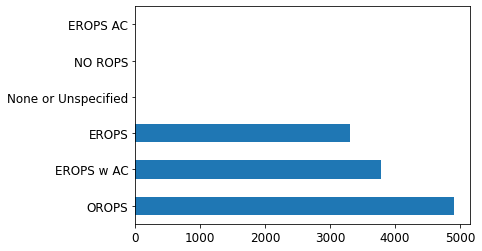

In [30]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh()

In [31]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_sum = x[flds].groupby("Enclosure", as_index=False).mean()
enc_sum

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.835050,0.246868
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.589106,0.233063
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.680000,0.199578


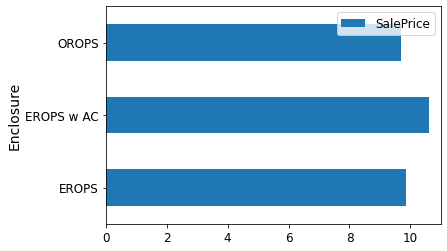

In [32]:
enc_sum = enc_sum[~pd.isnull(enc_sum.SalePrice)]
enc_sum.plot("Enclosure", "SalePrice", "barh", xlim=(0, 11))

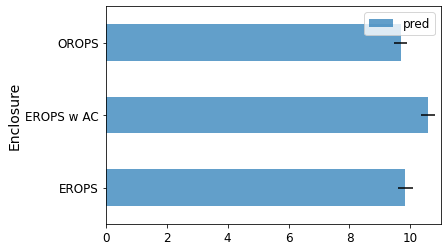

In [33]:
enc_sum.plot("Enclosure", "pred", "barh", xerr='pred_std', alpha=0.7, xlim=(0, 11))

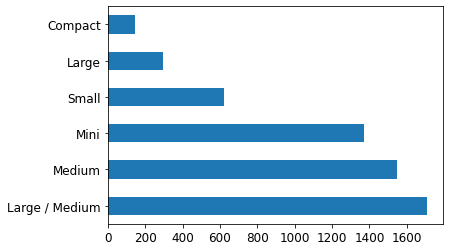

In [34]:
raw_valid.ProductSize.value_counts().plot.barh()

In [36]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby("ProductSize").mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.807040,0.291926
Large,10.470589,10.410170,0.327522
Large / Medium,10.691871,10.657185,0.268864
Medium,10.681511,10.625556,0.247282
Mini,9.535147,9.552551,0.220113
Small,10.324448,10.331690,0.274455


In [37]:
(summ.pred_std / summ.pred).sort_values(ascending=False)

ProductSize
Large             0.031462
Compact           0.029767
Small             0.026564
Large / Medium    0.025228
Medium            0.023272
Mini              0.023042
dtype: float64

### Feature Importance

In [38]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [39]:
fi = rf_feat_importance(m, df_trn)
fi[:10]

,cols,imp
5,YearMade,0.171845
13,ProductSize,0.095083
37,Coupler_System,0.089035
14,fiProductClassDesc,0.083341
2,ModelID,0.054088
62,saleElasped,0.053779
39,Hydraulics_Flow,0.050571
38,Grouser_Tracks,0.049983
10,fiSecondaryDesc,0.047795
19,Enclosure,0.034987


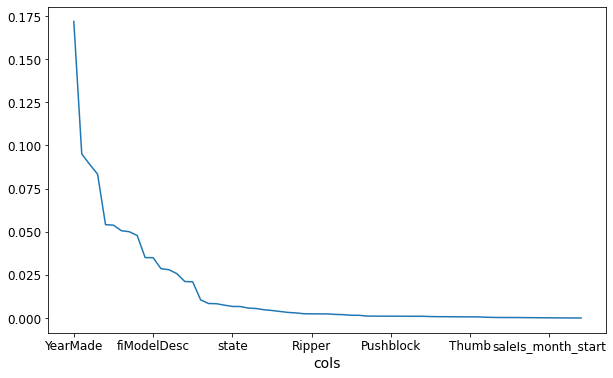

In [42]:
fi.plot('cols', 'imp', figsize=(10, 6), legend=False)

In [43]:
def plot_fi(fi):
    return fi.plot("cols", 'imp', 'barh', figsize=(12, 7), legend=False)

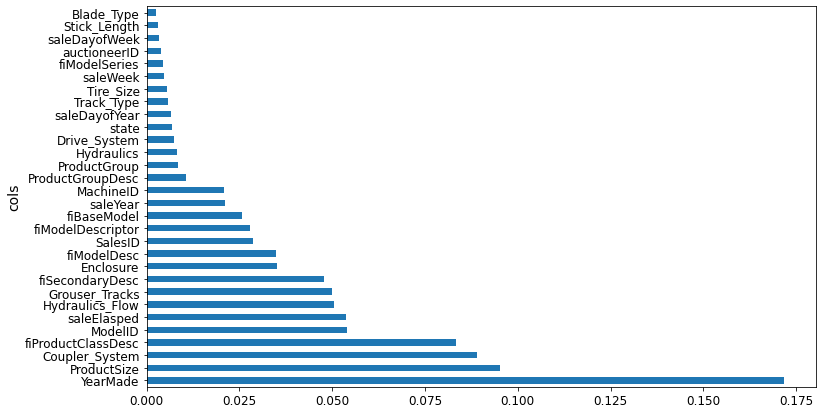

In [44]:
plot_fi(fi[:30])

In [45]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

24

In [47]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [48]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, min_samples_leaf=3, max_features = 0.5, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1251291090019646, 0.22426725146991008, 0.9672771192002543, 0.9101786258166343, 0.9127032660948791]


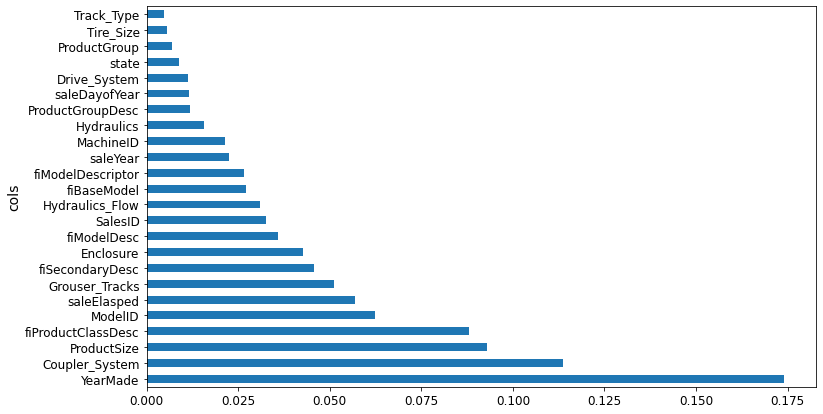

In [49]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi)